# Мультиклассовый SVM-классификатор (SVM-Support Vector Machine)
**Мовенко Константин**


Выполните задания блокнота и защитите результаты. Полностью заполненный блокнот необходимо сохранить и подгрузить в ЭОС. 

В этом блокноте необходимо:
    
- реализовать полностью векторизованную **функцию потерь** для SVM-классификатора
- реализовать  векторизованные вычисления её **аналитического градиента**
- **проверить свою реализацию** с помощью численного градиента
- использовать валидационное множество данных для подбора **скорости обучения и коэффициента регуляризации**
- **оптимизировать** функцию потерь с помощью алгоритма **SGD**
- **визуализировать** окончательные обученные веса классификатора

In [1]:
# Выполните начальные установки блокнота.
# Внимание! Блокнот работает в версии Python 3.6!

from __future__ import print_function
import random
import numpy as np
from dlcv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Команды для того, чтобы изображения matplotlib отображались в блокноте,
# а не в новом окне.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # установка размеров графиков по умолчанию
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Команды, необходимые для перезагрузки внешних модулей python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Загрузка базы данных CIFAR-10 и предобработка

In [2]:
# Загрузка данных из базы CIFAR-10.

cifar10_dir = 'dlcv/datasets/cifar-10-batches-py'

# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
    del X_train, y_train
    del X_test, y_test
    print('Очистка ранее загруженных данных')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Для проверки работоспособности распечатаем размер обучающих и тестовых данных.
print('Форма массива обучающих данных: ', X_train.shape)
print('Форма массива обучающих меток:', y_train.shape)
print('Форма массива тестовых данных:', X_test.shape)
print('Форма массива тестовых меток:', y_test.shape)

Форма массива обучающих данных:  (50000, 32, 32, 3)
Форма массива обучающих меток: (50000,)
Форма массива тестовых данных: (10000, 32, 32, 3)
Форма массива тестовых меток: (10000,)


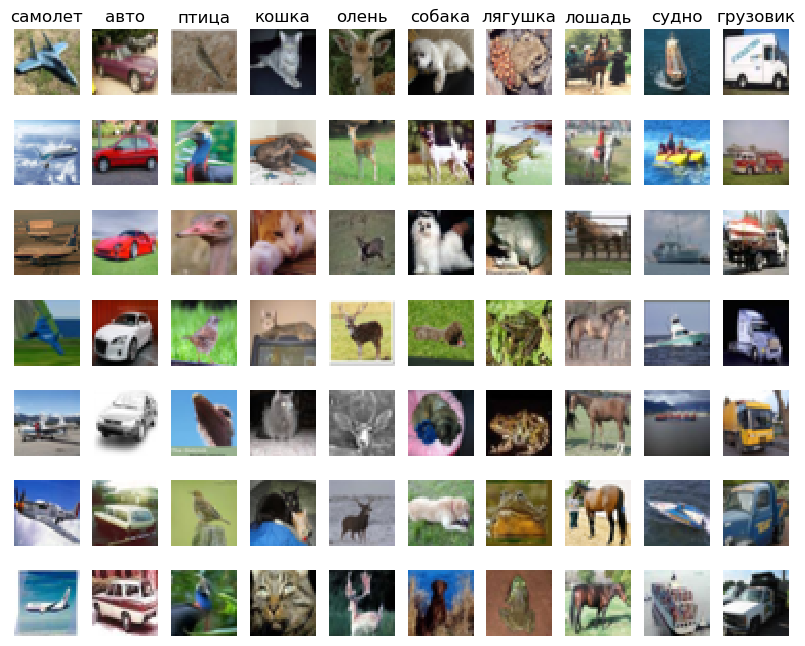

In [3]:
# Визуализируем некоторые изображения из набора данных.
# Покажем несколько примеров изображений из каждого класса.
classes = ['самолет', 'авто', 'птица', 'кошка', 'олень', 'собака', 'лягушка', 'лошадь', 'судно', 'грузовик']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Разделим данные на обучающие (train), валидационные(val) и тестовые (test). 
# Создадим небольшое множество данных для проведения экспериментов;
# Мы будем использовать это множество в процессе разработки, чтобы сократить время вычислений.
num_training = 49000        # размер обучающего мн-ва данных
num_validation = 1000       # размер валидационного мн-ва данных
num_test = 1000             # размер тестовогоо мн-ва данных
num_dev = 500               # размер мн-ва данных для использования в ходе разработки

# Валидационное множество содержит num_validation элементов исходного обучающего множества.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Обучающее множество содержит num_train элементов исходного обучающего множества.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Создание небольшого множества для разработки (X_dev, y_dev), которое является частью обучающего множества
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


# Использование первых num_test элементов исходного тестового множества в качестве тестового подмножества
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Форма  обучающего массива данных: ', X_train.shape)
print('Форма  обучающего массива меток: ', y_train.shape)
print('Форма  валидационного массива данных:  ', X_val.shape)
print('Форма  валидационного масссива меток:', y_val.shape)
print('Форма  тестового массива данных: ', X_test.shape)
print('Форма  тестового массива меток:', y_test.shape)

Форма  обучающего массива данных:  (49000, 32, 32, 3)
Форма  обучающего массива меток:  (49000,)
Форма  валидационного массива данных:   (1000, 32, 32, 3)
Форма  валидационного масссива меток: (1000,)
Форма  тестового массива данных:  (1000, 32, 32, 3)
Форма  тестового массива меток: (1000,)


In [5]:
# Предобработка: реформатирование изображений в векторы
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Для проверки распечатаем новые размерности данных
print('Размерность обучающего множества данных: ', X_train.shape)
print('Размерность валидационного множества данных:', X_val.shape)
print('Размерность тестового множества данных:', X_test.shape)
print('Размерность множества данных для разработки: ', X_dev.shape)

Размерность обучающего множества данных:  (49000, 3072)
Размерность валидационного множества данных: (1000, 3072)
Размерность тестового множества данных: (1000, 3072)
Размерность множества данных для разработки:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


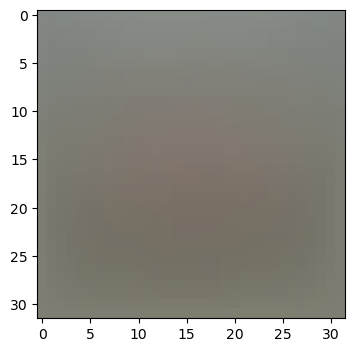

In [6]:
# Предобработка: вычитание среднего изображения
# 1: вычисляем среднее по обучающему массиву данных
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # вывод нескольких значений средних
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) #визуализация среднего изображения
plt.show()

In [7]:
# 2: вычитаем среднее изображение из обучающего и других массивов данных
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# 3: добавляем в матрицы данных справа вектор из единиц для учета смещения b в составе матрицы W при вычислении 
# s=Wx+b=w'x (трюк со смещением), в этом случае при оптимизации наm не нужно будет оптимизацировать отдельно смешения

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM классификатор

Написанный вами код для этой части задания должен быть размещен в файле **dlcv/classifiers/linear_svm.py**. 

Мы уже написали функцию `compute_loss_naive`, которая использует циклы for для оценки многоклассовой SVM функции потерь

In [9]:
# Проверьте наивную реализацию функции потерь, которую мы написали для Вас
from dlcv.classifiers.linear_svm import svm_loss_naive
import time

# создаем матрицу весов с небольшими случайными начальными значениями
W = np.random.randn(3073, 10) * 0.0001 

# проверякм вычисление SVM функции потерь на массиве данных для разработки
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('Потери: %f' % (loss, ))

Потери: 9.220778


Функция `svm_loss_naive`также вычисляет градиент `grad`. Чтобы понять вычисления, вспомните формулу градиента SVM функции потерь по весам W и просмотрите его вычисление внутри  функции `svm_loss_naive`. 

Чтобы убедиться, что функция правильно вычисляет аналитический градиент, сравните его с численной оценкой градиента с помощью кода, приведенного ниже:

In [10]:
# Вычисляем значение loss функции потерь и ее градиент grad по W, при отсутствии регуляризации (reg=0.0)

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Вычислияем численно градиент вдоль нескольких случайно выбранных измерений и
# сравниваем с аналитически вычисляемым градиентом. Числа должны совпадать
# почти точно по всем измерениям. По умолчанию выполняется 10 итераций.
print('1. Без регуляризации')
from dlcv.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Повторите проверку градиента с включенной регуляризацией (reg=5e1)
print('2. С регуляризацией')
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

1. Без регуляризации
численный: 2.575362 аналитический: 2.575362, относительная ошибка: 1.483506e-11
численный: 21.211326 аналитический: 21.211326, относительная ошибка: 8.464678e-12
численный: -3.406821 аналитический: -3.406821, относительная ошибка: 5.709564e-11
численный: -34.579471 аналитический: -34.579471, относительная ошибка: 1.595869e-12
численный: -2.042847 аналитический: -2.042847, относительная ошибка: 7.938555e-11
численный: -40.035735 аналитический: -40.035735, относительная ошибка: 2.802186e-12
численный: 8.500151 аналитический: 8.429109, относительная ошибка: 4.196388e-03
численный: 9.851963 аналитический: 9.851963, относительная ошибка: 8.505432e-12
численный: 14.374892 аналитический: 14.374892, относительная ошибка: 1.768529e-11
численный: -12.798464 аналитический: -12.798464, относительная ошибка: 8.429062e-12
2. С регуляризацией
численный: -20.063923 аналитический: -20.063923, относительная ошибка: 1.170396e-11
численный: 12.263175 аналитический: 12.263175, относите

### Вопрос 1:
Возможно, что по некоторым измерениям результаты проверки градиента не будут точно совпадать. Как могло возникнуть такое расхождение? Нужно ли беспокоиться? Какой простой пример в одномерном случае, для которого  проверка градиента может завершиться неудачей? Как влияет значение отступа (margin) на частоту этого события? *Подсказка: SVM функция потерь, строго говоря, не является дифференцируемой*



**Ваш ответ:** Если функция потерь не дифференцируема в некоторой точке, в близи неё при измерениях результаты проверки градиента могут не совпадать. Для стандартной функции потерь это точка *x=0*

Реализуйте в файле **dlcv/classifiers/linear_svm.py** векторизованные вычисления функции потерь `svm_loss_vectorized(W, X, y, reg)`; пока только вычислите потери, вычисление градиента реализуйте в следующей ячейке блокнота.

In [11]:
# Проверка векторизованной реализации функции svm_loss_vectorized(W, X, y, reg)
# Для проверки сравним результаты вычислений наивной функцией и векторизованной

tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Наивная функция потерь: %e вычислено за %fs' % (loss_naive, toc - tic))

from dlcv.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Векторизованная функция потерь: %e вычислено за %fs' % (loss_vectorized, toc - tic))

# Потери должны совпадать, но векторная реализация должна быть намного быстрее.
print('Отличие потерь: %f' % (loss_naive - loss_vectorized))

Наивная функция потерь: 9.220778e+00 вычислено за 0.040148s
Векторизованная функция потерь: 9.220778e+00 вычислено за 0.100097s
Отличие потерь: 0.000000


In [12]:
# Завершите реализацию svm_loss_vectorized и вычислите градиент
# функции потерь с помощью векторизованного кода.

# Результаты счета наивной и векторизованной реализаций должны совпадать, но
# векторизванная версия должна быть  быстрее.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Наивная функция потерь и градиент: вычислено за %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Векторизованная функция потерь и градиент: вычислено за %fs' % (toc - tic))

# Потери - это одно число, поэтому легко сравнивать вычисленные значения двумя реализациями функции.
# Градиенты, с другой стороны, являются матрицами, поэтому мы используем норму Фробениуса для их сравнения.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Отличие градиентов: %f' % difference)

Наивная функция потерь и градиент: вычислено за 0.029717s
Векторизованная функция потерь и градиент: вычислено за 0.010234s
Отличие градиентов: 0.000117


### Стохастический градиентный спуск (SGD- Stochastic Gradient Descent)

Теперь у нас есть векторизованные реализации функций для вычисления  потерь и градиента. Аналитический градиент соответствуют численному градиенту. Поэтому мы готовы применить SGD для минимизации потерь.

In [13]:
# В файле linear_classifier.py реализуйте алгоритм SGD в функции
# LinearClassifier.train(), а затем запустите его с помощью кода ниже.

from dlcv.classifiers import LinearSVM

svm = LinearSVM()        # создаем объект svm класса LinearSVM - линейный SVM классификатор
tic = time.time()

# вызываем метод объекта svm.train, выполняющий обучение линейной части s=Wx,
# и проводим обучение на обучающих массивах данных: X_train, y_train
# метод оптимизирует матрицу весов W и возвращает список значений потерь на каждой итерации
# learning_rate - скорость обучения, reg - коэффициент регуляризации, num_iters - число итераций
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

toc = time.time()
print('Время обучения %fs' % (toc - tic))


итерация 0 / 1500: потери 402.448279
итерация 100 / 1500: потери 240.167589
итерация 200 / 1500: потери 146.631737
итерация 300 / 1500: потери 90.392219
итерация 400 / 1500: потери 56.420333
итерация 500 / 1500: потери 36.091484
итерация 600 / 1500: потери 23.353737
итерация 700 / 1500: потери 16.975602
итерация 800 / 1500: потери 11.798627
итерация 900 / 1500: потери 9.553181
итерация 1000 / 1500: потери 7.547422
итерация 1100 / 1500: потери 6.163270
итерация 1200 / 1500: потери 5.698762
итерация 1300 / 1500: потери 5.230994
итерация 1400 / 1500: потери 5.236098
Время обучения 4.840066s


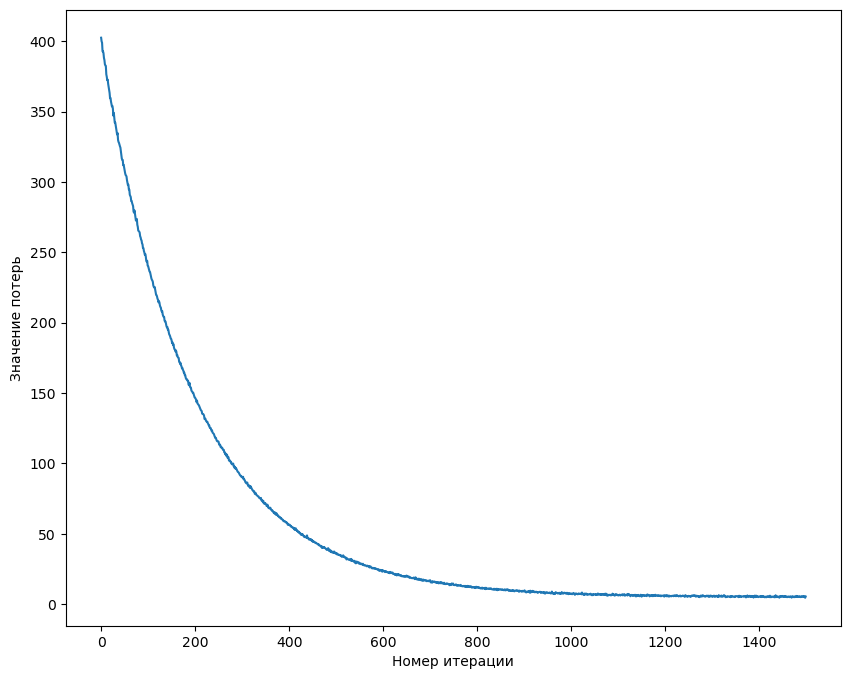

In [14]:
# Полезная стратегия отладки заключается в том, чтобы вычислять потери как функцию
# от номера итерации. Построим график функции потерь
plt.plot(loss_hist)
plt.xlabel('Номер итерации')
plt.ylabel('Значение потерь')
plt.show()

In [15]:
# Опрделите метод LinearSVM.predict и оцените эффективность классификации как на
# тренировочном, так и на проверочном множествах данных

y_train_pred = svm.predict(X_train)   # предсказываем метку каждого изображения из X_train

# Точность - это доля данных, которые правильно классифицированы (предсказаны),
# она равна среднему числу совпадений предсказанных меток с реальными метками
print('Точность обучения: %f' % (np.mean(y_train == y_train_pred), ))

y_val_pred = svm.predict(X_val)       # предсказываем метку каждого изображения из X_val
print('Валидационная точность: %f' % (np.mean(y_val == y_val_pred), ))

Точность обучения: 0.380510
Валидационная точность: 0.391000


In [16]:
# Используйте валидационное мн-во для выбора гиперпараметров (коэффициента регуляризации и скорости обучения). 
# Вы должны экспериментировать с различными значениями скорости обучения и коэффициента регуляризации;
# вы должны получить точность классификации примерно 0,4 на валидационном мн-ве данных.

learning_rates = [1.5e-7, 2e-7, 2.5e-7, 3e-7]         # задайте различные значения скорости обучения (4 варианта!)
regularization_strengths = [12e3, 13e3, 14e-3, 15e3]  # задайте различные значения коэффициента регуляризации (4 варианта!)

# results - словарь, отображающий кортежи вида (learning_rate, regularization_strength)
# в кортежи вида (training_accuracy, validation_accuracy). 
results = {}

best_val = -1   # начальное значение наивысшей валидационной точности
best_svm = None # Объект LinearSVM, для которого будет получена наивысшая валидац. точность.

################################################################################
# ЗАДАНИЕ:  Ознакомьтесь с кодом ниже                                          #
# Написанный код, который выбирает лучшие гиперпараметры, используя            #
# валидационное мн-во. Для каждой комбинации гиперпараметров обучается         #
# линейный SVM (на обучающем множестве), определяется точность на обучающем и  #
# валидационном мн-вах, которая сохраняется в словаре результатов. Кроме того, #
# сохраняется лучшая валидац. точность в best_val, а объект LinearSVM, для     #
# которого достигнута эта точность, сохраняется в best_svm.                    #
#                                                                              #
# Совет: вы должны использовать небольшое значение для num_iters при           #
# разработке своего валидационного кода, чтобы SVM не требовал много времени   #
# для обучения; как только вы будете уверены, что код работает, вы должны      #
# повторно запустить валидационный код с большим значением для num_iters.      #
################################################################################
# КОД ДЛЯ ОЗНАКОМЛЕНИЯ
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=800, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_accuracy=np.mean(y_train == y_train_pred)
        print('lr=%e reg=%e' % (lr, reg))
        print('Точность обучения: %f' % train_accuracy)
               
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        print('Валидационная точность: %f' % val_accuracy)
        results[(lr,reg)] = (train_accuracy,val_accuracy)
################################################################################
#                              КОНЕЦ ВАШЕГО КОДА                               #
################################################################################
    
# Вывод результатов
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)] 
    print('lr %e reg %e точность обучения: %f валидационная точность: %f' % (
                lr, reg, train_accuracy, val_accuracy))
print('Наилучшая валидационная точность полученная в ходе кросс-валидации: %f' % best_val)

итерация 0 / 800: потери 205.022553
итерация 100 / 800: потери 136.954992
итерация 200 / 800: потери 95.617720
итерация 300 / 800: потери 66.927583
итерация 400 / 800: потери 48.390468
итерация 500 / 800: потери 34.217617
итерация 600 / 800: потери 24.659676
итерация 700 / 800: потери 19.000922
lr=1.500000e-07 reg=1.200000e+04
Точность обучения: 0.358551
Валидационная точность: 0.359000
итерация 0 / 800: потери 226.869905
итерация 100 / 800: потери 145.321277
итерация 200 / 800: потери 98.560676
итерация 300 / 800: потери 67.532562
итерация 400 / 800: потери 46.515259
итерация 500 / 800: потери 33.486487
итерация 600 / 800: потери 23.115067
итерация 700 / 800: потери 17.615015
lr=1.500000e-07 reg=1.300000e+04
Точность обучения: 0.370735
Валидационная точность: 0.366000
итерация 0 / 800: потери 20.631575
итерация 100 / 800: потери 9.146061
итерация 200 / 800: потери 9.890030
итерация 300 / 800: потери 9.102970
итерация 400 / 800: потери 7.788509
итерация 500 / 800: потери 8.198268
итера

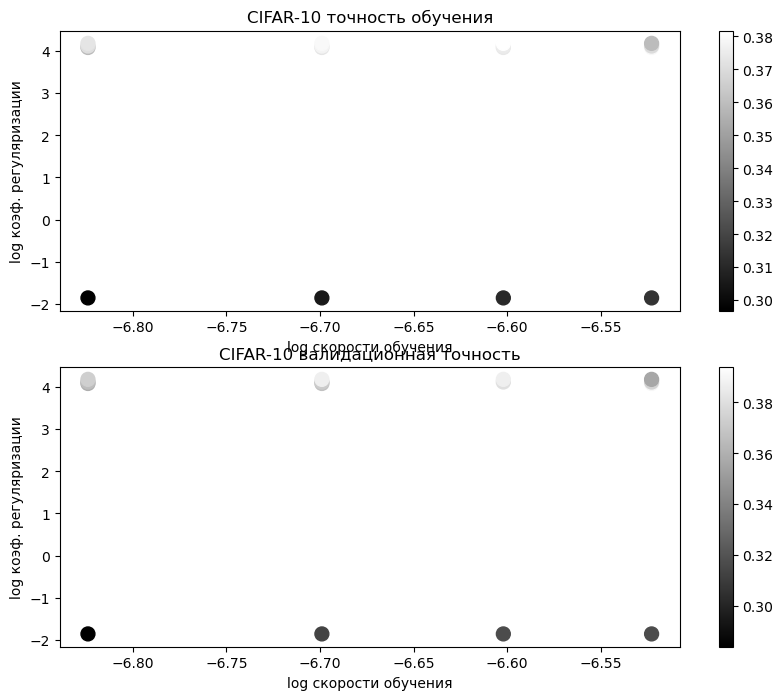

In [17]:
# Визуализация результатов кросс-валидации
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# отображение точности обучения
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log скорости обучения')
plt.ylabel('log коэф. регуляризации')
plt.title('CIFAR-10 точность обучения')

# отображение точности валидации
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log скорости обучения')
plt.ylabel('log коэф. регуляризации')
plt.title('CIFAR-10 валидационная точность')
plt.show()

In [18]:
# Оценивание лучшего SVM классификатора на тестовом массиве данных
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Линейный классификатор SVM на сырых данных, финальная точность на тестовом наборе данных: %f' % test_accuracy)

Линейный классификатор SVM на сырых данных, финальная точность на тестовом наборе данных: 0.360000


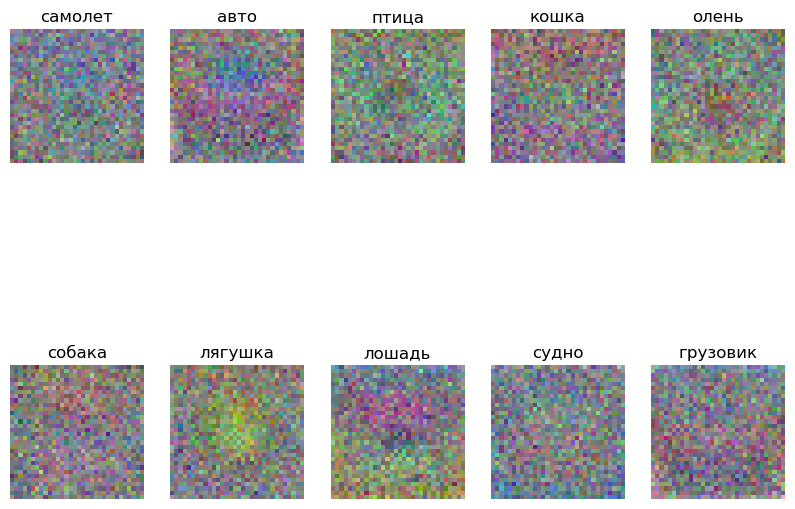

In [19]:
# Визуализация обученных весов для каждого класса.
# В зависимости от выбора скорости обучения и коэфф. регуляризации 
# визуализации будут выглядеть по-разному.


w = best_svm.W[:-1,:]               # исключаем смещение
w = w.reshape(32, 32, 3, 10)        # приводим к размерам исходных изображений
w_min, w_max = np.min(w), np.max(w)
classes = ['самолет', 'авто', 'птица', 'кошка', 'олень', 'собака', 'лягушка', 'лошадь', 'судно', 'грузовик']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Масштабирование весов, чтобы они были в диапазоне от 0 до 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Вопрос  2:

Опишите ваши визуализированные веса SVM классификатора, и дайте краткое объяснение, почему они выглядят таким образом.

**Ваш ответ:** визуализации весов SVM-классификатора отдалённо напоминают контур соответствующих объектов, на которые они должны реагировать. Это ожидаемый результат, так как каждая матрица весов формировалась под определённый класс изображений. Тем не менее, полученный результат не даёт достаточно высокой точности распознавания класса изображения.